# Loan Denial Analysis


## Introduction
This notebook explores a dataset to analyze factors influencing loan denial. The goal is to build a predictive model to identify potential loan denials based on key features.

In [10]:

# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


## Load and Explore Dataset

In [ ]:
# Load dataset

loan_data = pd.read_csv('../Notebook/data/loan_data.csv')

# Display the first few rows
loan_data.head()

# Basic dataset information
loan_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

## Handle Missing Values

In [12]:
# Check for missing values
missing_values = loan_data.isnull().sum()
print("Missing Values:\n", missing_values)

# Drop rows with missing target variable
loan_data = loan_data.dropna(subset=['loan_status'])

# Fill missing numerical features with median
for col in loan_data.select_dtypes(include=['float64', 'int64']).columns:
    loan_data[col] = loan_data[col].fillna(loan_data[col].median())

# Fill missing categorical features with the mode
for col in loan_data.select_dtypes(include=['object']).columns:
    loan_data[col] = loan_data[col].fillna(loan_data[col].mode()[0])

# Encode categorical variables
label_encoders = {}
for col in loan_data.select_dtypes(include=['object']).columns:
    label_encoders[col] = LabelEncoder()
    loan_data[col] = label_encoders[col].fit_transform(loan_data[col])

    

Missing Values:
 person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


## Exploratory Data Analysis (EDA)

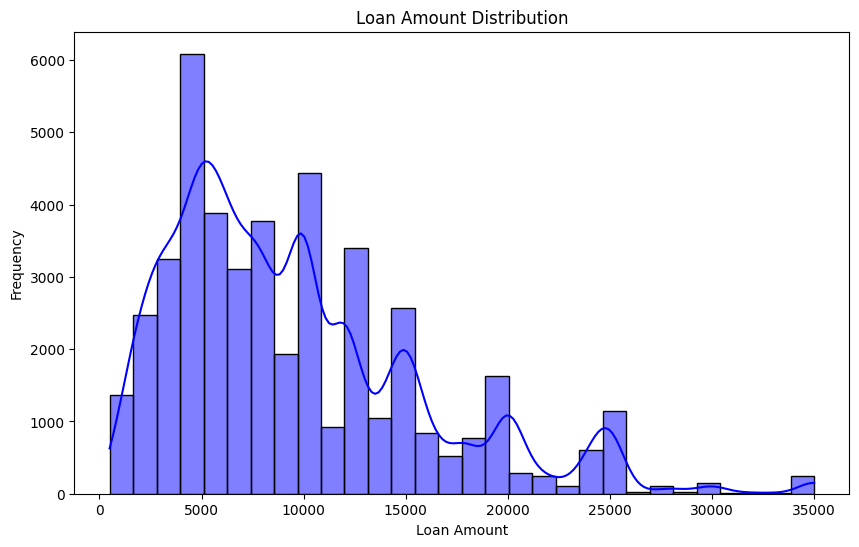

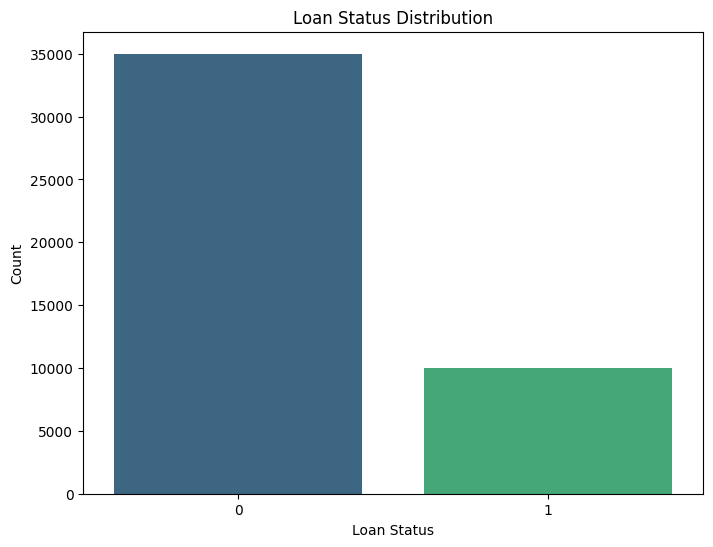

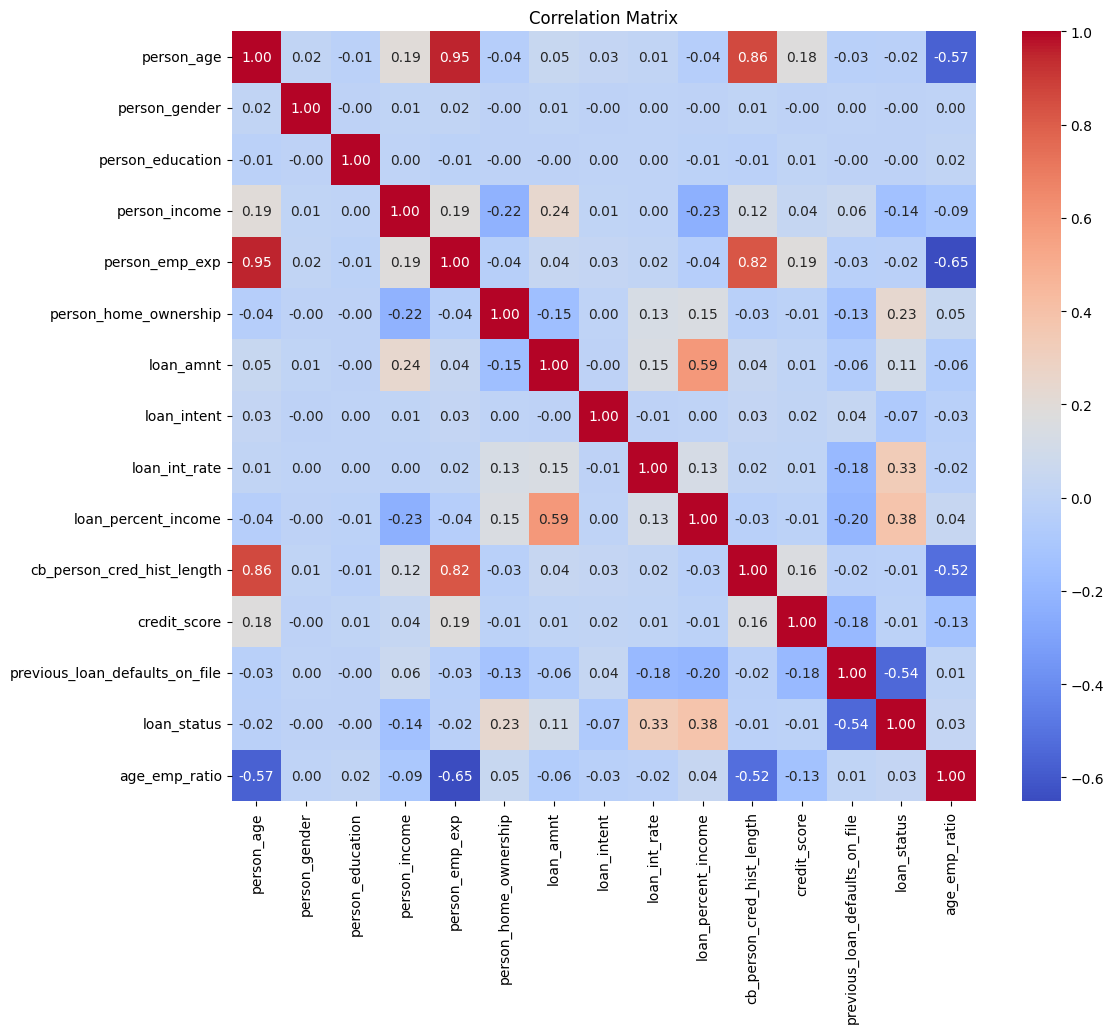

In [19]:

# Distribution of loan amounts
plt.figure(figsize=(10, 6))
sns.histplot(loan_data['loan_amnt'], kde=True, bins=30, color='blue')
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

# Loan status count
plt.figure(figsize=(8, 6))
sns.countplot(data=loan_data, x='loan_status', hue='loan_status', palette='viridis', legend=False)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = loan_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


## Feature Engineering

In [ ]:
# Combine strongly correlated features
loan_data['age_emp_ratio'] = loan_data['person_age'] / (loan_data['person_emp_exp'] + 1)

## Model Building and Hyperparameter Tuning

In [25]:
# Select features for the model
selected_features = [
    'loan_percent_income', 
    'previous_loan_defaults_on_file', 
    'loan_int_rate', 
    'loan_amnt', 
    'age_emp_ratio'
]
X = loan_data[selected_features]
y = loan_data['loan_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 20],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}
Accuracy on Test Set: 0.9088888888888889

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      7000
           1       0.82      0.75      0.79      2000

    accuracy                           0.91      9000
   macro avg       0.88      0.85      0.86      9000
weighted avg       0.91      0.91      0.91      9000



## Feature Importance

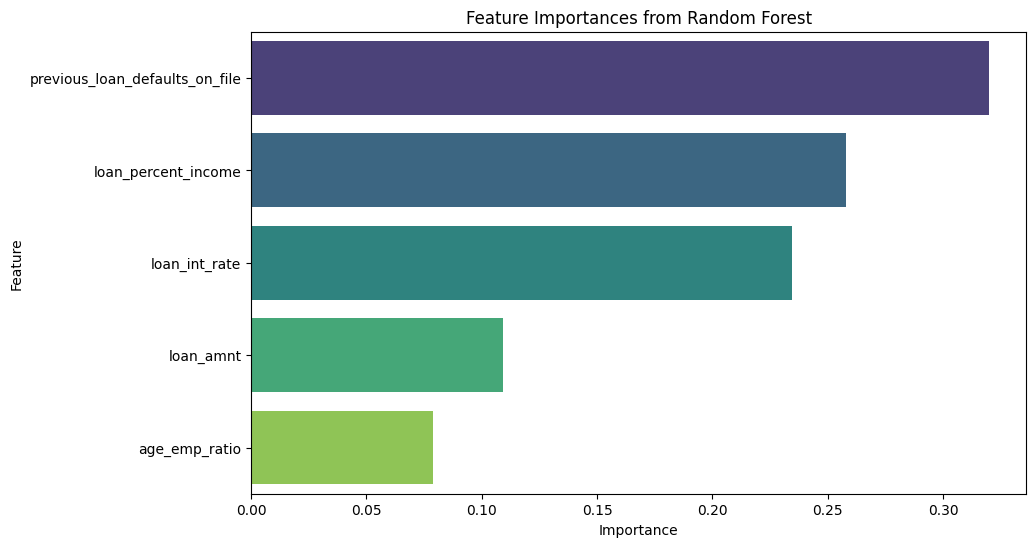

In [26]:

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importances, palette='viridis', legend=False)
plt.title('Feature Importances from Random Forest')
plt.show()


## Evaluation using LightGXM


In [27]:
import lightgbm as lgb

# LightGBM Model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Hyperparameter tuning with GridSearchCV
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100]
}

lgb_grid_search = GridSearchCV(estimator=lgb_model, param_grid=lgb_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
lgb_grid_search.fit(X_train_scaled, y_train)

# Best model evaluation
lgb_best_model = lgb_grid_search.best_estimator_
lgb_y_pred = lgb_best_model.predict(X_test_scaled)

print("Best Hyperparameters for LightGBM:", lgb_grid_search.best_params_)
print("Accuracy on Test Set with LightGBM:", accuracy_score(y_test, lgb_y_pred))
print("\nClassification Report for LightGBM:\n", classification_report(y_test, lgb_y_pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 8000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222222 -> initscore=-1.252763
[LightGBM] [Info] Start training from score -1.252763
Best Hyperparameters for LightGBM: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 50}
Accuracy on Test Set with LightGBM: 0.9084444444444445

Classification Report for LightGBM:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      7000
           1       0.83      0.74      0.78      2000

    accurac